In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
from cuml.manifold import TSNE as cu_TSNE
from cuml.manifold import UMAP as cu_UMAP
from sklearn.decomposition import PCA as sk_PCA
from sklearn.manifold import TSNE as sk_TSNE
from umap import UMAP as sk_UMAP
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import trustworthiness
from cuml.decomposition import PCA as cu_PCA
from cuml.metrics import trustworthiness as cu_trustworthiness
import cudf

RDKit WARNING: [18:16:20] Enabling RDKit 2019.09.3 jupyter extensions


A few settings to make the plots look the way I want them to

In [2]:
sns.set(rc={'figure.figsize': (7, 7)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

Read the data

In [3]:
df = pd.read_csv("chembl_drugs.smi",sep=" ",header=None)

In [4]:
df.columns = ["SMILES","Name"]

In [5]:
df.shape

(1495, 2)

Define a function to generate fingerprints with the RDKit

In [6]:
def fp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        fp_list.append(fp_as_array(mol,n_bits))
    return fp_list

def fp_as_array(mol,n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,), np.int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

Generate fingerprints

In [7]:
fp_list = fp_list_from_smiles_list(df.SMILES,512)

### t-SNE Using sklearn

Reduce the dimensionality of the fingerprints with PCA

In [8]:
n_components = 50

In [9]:
sk_fp_pc = sk_PCA(n_components=n_components).fit_transform(fp_list)

Run t-SNE using sklearn

In [10]:
sk_tsne = sk_TSNE(n_components=2, method='barnes_hut', n_jobs=-1,random_state=23)
%time sk_embedding = sk_tsne.fit_transform(sk_fp_pc)

CPU times: user 1min 23s, sys: 1.28 s, total: 1min 24s
Wall time: 3.67 s


In [11]:
sk_trust = trustworthiness(sk_fp_pc,sk_embedding)
sk_trust

0.968023517081147

### t-SNE using RAPIDS

A function from the RAPIDS demos to convert a numpy array to cudf

In [12]:
def np2cudf(arr):
    # convert numpy array to cudf dataframe
    df = pd.DataFrame({'fea%d'%i:arr[:,i] for i in range(arr.shape[1])})
    pdf = cudf.DataFrame()
    for c,column in enumerate(df):
        pdf[str(c)] = df[column]
    return pdf

In [13]:
cu_fp_df = np2cudf(np.array(fp_list,dtype=np.float32))

In [14]:
cu_fp_pc = cu_PCA(n_components=n_components).fit_transform(cu_fp_df)

Run TSNE with RAPIDS

In [15]:
cu_tsne = cu_TSNE(n_components = 2, method = 'barnes_hut',random_state=23)

In [16]:
%time cu_embedding = cu_tsne.fit_transform(cu_fp_pc)

CPU times: user 250 ms, sys: 320 ms, total: 570 ms
Wall time: 569 ms


In [17]:
cu_trust = cu_trustworthiness(cu_fp_pc,cu_embedding)
cu_trust

/home/pwalters/anaconda3/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 
  """Entry point for launching an IPython kernel.


0.9230161061417458

Combine the scikit-learn and RAPIDS results so that we can compare

In [18]:
sk_df = pd.DataFrame(sk_embedding,columns=["X","Y"])
sk_df['Method'] = "sklearn"
cu_df = pd.DataFrame(cu_embedding.values,columns=["X","Y"])
cu_df["Method"] = "rapids"
tsne_combo_df = sk_df.append(cu_df)

Plot the comparison

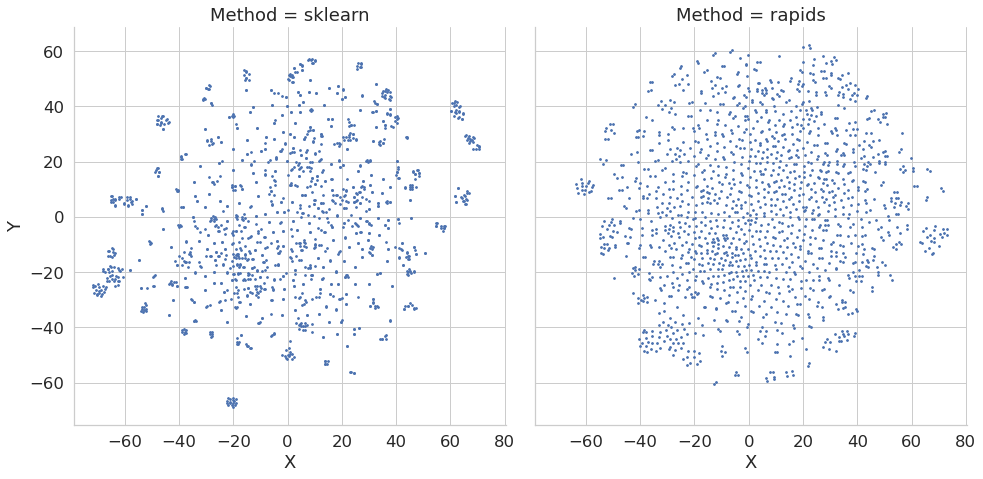

In [19]:
g = sns.FacetGrid(tsne_combo_df, col="Method",height=7)
g.map(plt.scatter, "X", "Y",s=3)

### UMAP with sklearn

In [20]:
n_neighbors = 4
sk_umap = sk_UMAP(n_neighbors=n_neighbors, min_dist=0.1, verbose=False)

In [21]:
desc = np.array(fp_list)
%time sk_ut = sk_umap.fit_transform(desc)

/home/pwalters/anaconda3/envs/rapids/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


CPU times: user 37.5 s, sys: 281 ms, total: 37.8 s
Wall time: 7.83 s


In [22]:
trustworthiness(desc,sk_ut)

0.8820584193444636

### UMAP with RAPIDS

In [23]:
n_neighbors = 4
cu_umap = cu_UMAP(n_neighbors=n_neighbors, min_dist=0.1, verbose=False)

In [24]:
%time cu_ut = cu_umap.fit_transform(cu_fp_df)

CPU times: user 777 ms, sys: 252 ms, total: 1.03 s
Wall time: 914 ms


In [25]:
cu_trustworthiness(cu_fp_df,cu_ut)

/home/pwalters/anaconda3/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 
  """Entry point for launching an IPython kernel.


0.8801934266429456

Plot the UMAP transformed data

In [26]:
sk_df = pd.DataFrame(sk_ut,columns=["X","Y"])
sk_df['Method'] = "sklearn"
cu_df = pd.DataFrame(cu_ut.values,columns=["X","Y"])
cu_df["Method"] = "rapids"
umap_combo_df = sk_df.append(cu_df)

Plot the comparison the scikit-learn and RAPIDS maps

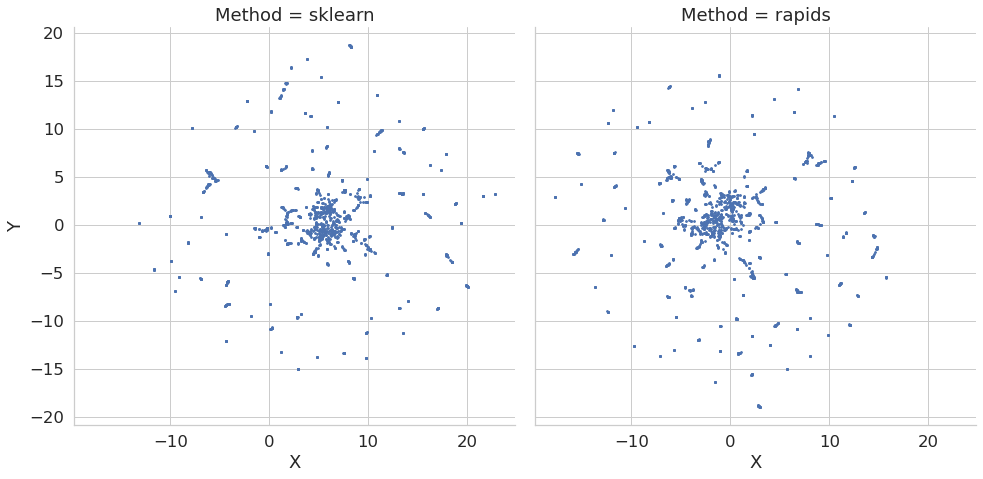

In [27]:
g = sns.FacetGrid(umap_combo_df, col="Method",height=7)
g.map(plt.scatter, "X", "Y",s=3)

Evaluate trustworthiness as a function of the number of neighbors

In [28]:
umap_nbr_df = pd.DataFrame()
nbr_trust_lst = []
for i in tqdm(range(2,10)):
    n_neighbors = i
    umap = cu_UMAP(n_neighbors=n_neighbors, min_dist=0.01, verbose=False)
    ut = umap.fit_transform(cu_fp_df)
    nbr_trust_lst.append([i,cu_trustworthiness(cu_fp_df,ut)])
    tmp_df = pd.DataFrame(ut.values,columns=["X","Y"])
    tmp_df["nbrs"] = i
    umap_nbr_df = umap_nbr_df.append(tmp_df)

/home/pwalters/anaconda3/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 
  import sys


Plot trustworthiness as a function of the number of neighbors

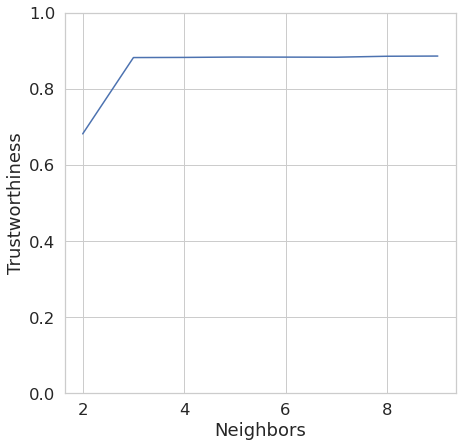

In [29]:
x = np.array(nbr_trust_lst)[:,0]
y = np.array(nbr_trust_lst)[:,1]
ax = sns.lineplot(x,y)
_ = ax.set(xlabel="Neighbors",ylabel="Trustworthiness",ylim=[0,1])

Plot maps for number of neighbors between 2 and 9

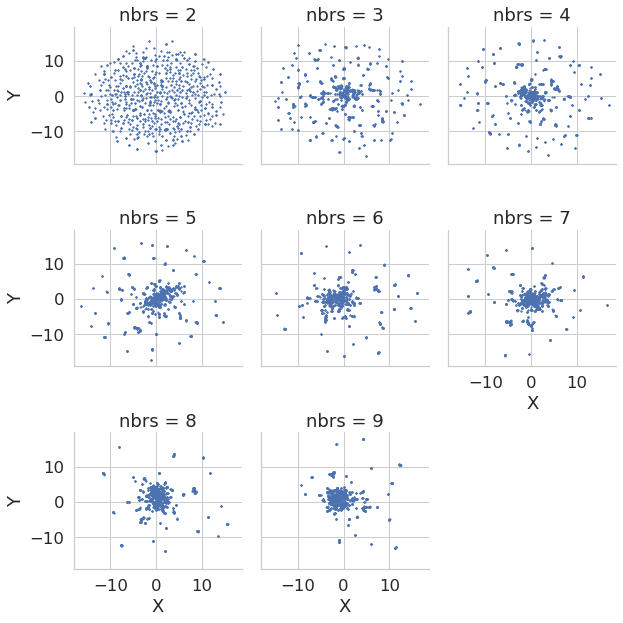

In [30]:
g = sns.FacetGrid(umap_nbr_df,col="nbrs",col_wrap=3)
g.map(plt.scatter, "X", "Y",s=1)

Evaluate trustworthiness as a function of minimum distance

In [31]:
umap_dist_df = pd.DataFrame()
md_trust_lst = []
for i in tqdm(np.arange(0.1,1,0.1)):
    n_neighbors = 4
    umap = cu_UMAP(n_neighbors=n_neighbors, min_dist=i, verbose=False)
    ut = umap.fit_transform(cu_fp_df)
    md_trust_lst.append([i,cu_trustworthiness(cu_fp_df,ut)])
    tmp_df = pd.DataFrame(ut.values,columns=["X","Y"])
    tmp_df["min_dist"] = f"{i:.2f}"
    umap_dist_df = umap_dist_df.append(tmp_df)

/home/pwalters/anaconda3/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Parameter should_downcast is deprecated, use convert_dtype instead. 
  import sys


Plot trustworthiness as a function of minimum distance

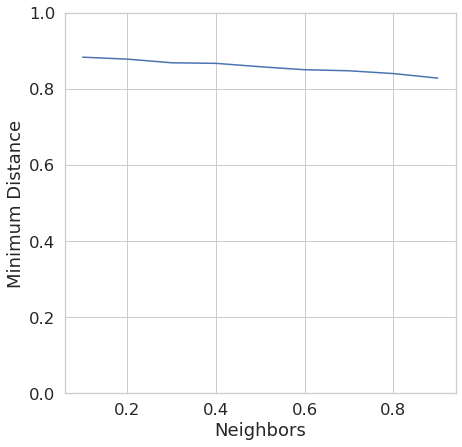

In [32]:
x = np.array(md_trust_lst)[:,0]
y = np.array(md_trust_lst)[:,1]
ax = sns.lineplot(x,y)
_ = ax.set(xlabel="Neighbors",ylabel="Minimum Distance",ylim=[0,1])

Plot maps for minimum distance between 0.1 and 0.9

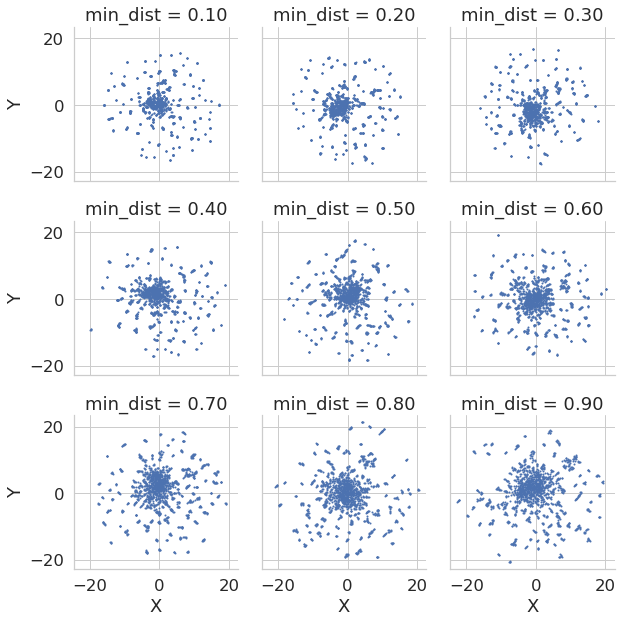

In [33]:
g = sns.FacetGrid(umap_dist_df,col="min_dist",col_wrap=3)
g.map(plt.scatter, "X", "Y",s=1)